Funziona: https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial119_multiclass_semantic_segmentation.ipynb

In [1]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import load_model
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
#from tensorflow.keras.optimizers import SGD, Adam
from typing import Tuple

Segmentation Models: using `keras` framework.


In [2]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [3]:

# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = resize_with_pad(image, (sx, sy)) #Mantengo la giusta proporzione e aggiungo del padding
        image_dataset.append(image)
    return image_dataset

In [4]:
# loading mask data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path, 0)
        image = resize_with_pad(image, (sx, sy))
        image_dataset.append(image)
    return image_dataset

In [5]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 256
size_y = 256

image_dataset = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
#Espando la dimensione  della maschera
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)

In [6]:
print(image_dataset.shape)
print(mask_dataset_encoded.shape)
print("Image shape: ", image_dataset[0].shape)
print("Mask shape: ", mask_dataset_encoded[0].shape)
print("Max pixel value in image is: ", image_dataset.max()) #255 perchè non è normalizzata
print("Labels in the mask are : ", np.unique(mask_dataset_encoded))

(1688, 256, 256, 3)
(1688, 256, 256, 1)
Image shape:  (256, 256, 3)
Mask shape:  (256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [7]:

#Normalize images (pixel diventano tra 0 e 1)
image_dataset = image_dataset /255. 

In [8]:
#Split training datafrom sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")    

Dimensione training set: 1080
Dimensione val set: 270
Dimensione test set: 338


In [9]:
#Le maschere devono avere il formato dell'ultimo layer del modello (256x256x5)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat =val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))
print("shape precedente: ", y_train.shape)
print("shape attuale: ", y_train_cat.shape)


shape precedente:  (1080, 256, 256, 1)
shape attuale:  (1080, 256, 256, 5)


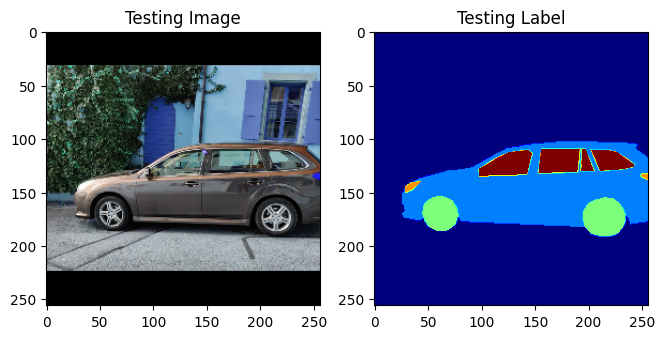

In [10]:
#Sanity check delle immagini
n = random.randint(0, len(X_test)-1)
test_img = X_train[n]
ground_truth=y_train[n]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
# Building Unet by dividing encoder and decoder into blocks
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p  
#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model 


In [12]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 3)


In [13]:
model = build_unet(input_shape, n_classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(1080, 256, 256, 3)
(338, 256, 256, 3)
(1080, 256, 256, 5)
(338, 256, 256, 5)


In [15]:
from keras.callbacks import CSVLogger
#Fase di TRAINING del modello, early stopping con pazienza a 5
csv_logger = CSVLogger('UNet_256.log', separator=',', append=False)
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
percorso = os.path.join("..",'UNet_256.hdf5')
m_save = ModelCheckpoint(percorso, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_val, y_val_cat), 
                    callbacks=[callbacks,csv_logger, m_save],
                    shuffle=False)

Epoch 1/25
68/68 [==============================] - 3885s 57s/step - loss: 0.6727 - accuracy: 0.7886 - val_loss: 136.6866 - val_accuracy: 0.1669
Epoch 2/25
68/68 [==============================] - 3626s 53s/step - loss: 0.3553 - accuracy: 0.8808 - val_loss: 2.6256 - val_accuracy: 0.5723
Epoch 3/25
68/68 [==============================] - 3534s 52s/step - loss: 0.2479 - accuracy: 0.9140 - val_loss: 1.3505 - val_accuracy: 0.7305
Epoch 4/25
68/68 [==============================] - 3566s 52s/step - loss: 0.1994 - accuracy: 0.9297 - val_loss: 1.3818 - val_accuracy: 0.7639
Epoch 5/25
68/68 [==============================] - 3554s 52s/step - loss: 0.1675 - accuracy: 0.9403 - val_loss: 0.9261 - val_accuracy: 0.7683
Epoch 6/25
68/68 [==============================] - 3733s 55s/step - loss: 0.1491 - accuracy: 0.9468 - val_loss: 0.7728 - val_accuracy: 0.8112
Epoch 7/25
68/68 [==============================] - 3710s 54s/step - loss: 0.1383 - accuracy: 0.9505 - val_loss: 0.3390 - val_accuracy: 0.90

In [12]:
from keras.callbacks import CSVLogger
#Fase di TRAINING del modello, early stopping con pazienza a 3
csv_logger = CSVLogger('UNet_256_p2.log', separator=',', append=False)
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]
percorso = os.path.join("..",'UNet_256.hdf5')
percorso2 = os.path.join("..",'UNet_256_p2.h5')
m_save = ModelCheckpoint(percorso2, save_best_only=True, monitor='val_loss', mode='min')

new_model = load_model(percorso)

history = new_model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=6, 
                    validation_data=(X_val, y_val_cat), 
                    callbacks=[callbacks,csv_logger, m_save],
                    shuffle=False)

Epoch 1/6
68/68 [==============================] - 3172s 46s/step - loss: 0.0942 - accuracy: 0.9658 - val_loss: 0.1762 - val_accuracy: 0.9416
Epoch 2/6
68/68 [==============================] - 3008s 44s/step - loss: 0.0876 - accuracy: 0.9683 - val_loss: 0.2078 - val_accuracy: 0.9317
Epoch 3/6
68/68 [==============================] - 3035s 45s/step - loss: 0.0824 - accuracy: 0.9702 - val_loss: 0.1268 - val_accuracy: 0.9581
Epoch 4/6
68/68 [==============================] - 3066s 45s/step - loss: 0.0987 - accuracy: 0.9647 - val_loss: 2.5463 - val_accuracy: 0.5712
Epoch 5/6
68/68 [==============================] - 3048s 45s/step - loss: 0.0947 - accuracy: 0.9657 - val_loss: 0.1940 - val_accuracy: 0.9358
Epoch 6/6
68/68 [==============================] - 3084s 45s/step - loss: 0.0836 - accuracy: 0.9698 - val_loss: 0.1172 - val_accuracy: 0.9600


In [14]:
from keras.callbacks import CSVLogger
#Fase di TRAINING del modello, early stopping con pazienza a 3
csv_logger = CSVLogger('UNet_256_p3.log', separator=',', append=False)
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]
percorso = os.path.join("..",'UNet_256_p2.h5')
percorso2 = os.path.join("..",'UNet_256_p3.hdf5')
m_save = ModelCheckpoint(percorso2, save_best_only=True, monitor='val_loss', mode='min')

new_model = load_model(percorso)

history = new_model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_val, y_val_cat), 
                    callbacks=[callbacks,csv_logger, m_save],
                    shuffle=False)

Epoch 1/10
68/68 [==============================] - 3599s 53s/step - loss: 0.0725 - accuracy: 0.9736 - val_loss: 0.1030 - val_accuracy: 0.9654
Epoch 2/10
68/68 [==============================] - 3532s 52s/step - loss: 0.0649 - accuracy: 0.9763 - val_loss: 0.0767 - val_accuracy: 0.9727
Epoch 3/10
68/68 [==============================] - 3554s 52s/step - loss: 0.0588 - accuracy: 0.9785 - val_loss: 0.0842 - val_accuracy: 0.9708
Epoch 4/10
68/68 [==============================] - 3568s 52s/step - loss: 0.0550 - accuracy: 0.9799 - val_loss: 0.0815 - val_accuracy: 0.9721
Epoch 5/10
68/68 [==============================] - 3576s 53s/step - loss: 0.0520 - accuracy: 0.9811 - val_loss: 0.0804 - val_accuracy: 0.9728


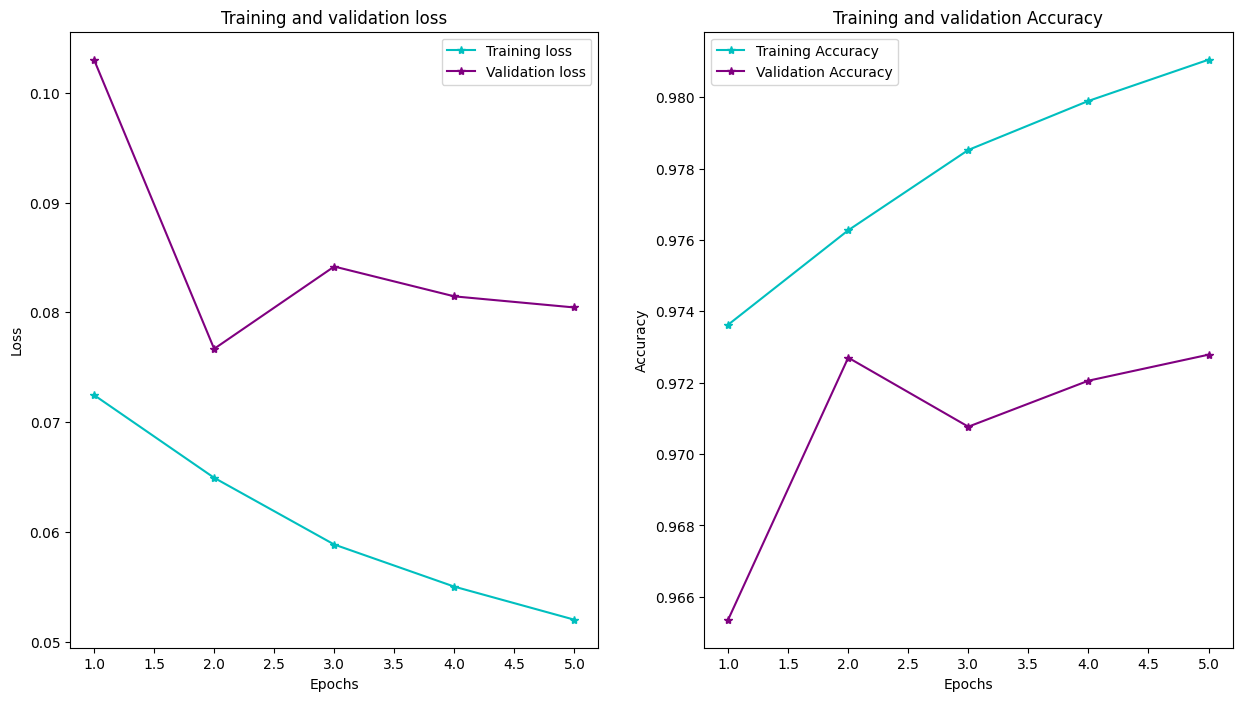

In [15]:
fig = plt.figure(figsize=(15, 8))
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'c', marker="*", label='Training loss')
plt.plot(epochs, val_loss,'purple', marker="*", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'c', marker="*", label='Training Accuracy')
plt.plot(epochs, val_acc, 'purple', marker="*", label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')


In [16]:
#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "UNet_256_p3.hdf5")
model = load_model(path) #tf.keras.models.load_model
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
y_pred=model.predict(X_test)
y_pred.shape #5 canali (correttamente)

11/11 [==============================] - 233s 21s/step


(338, 256, 256, 5)

In [18]:
#Argmax controlla il valore maggiore dell'asse indicato e prende solo quello
y_pred_argmax=np.argmax(y_pred, axis=3) 
y_pred_argmax.shape

(338, 256, 256)

1/1 [==============================] - 1s 707ms/step


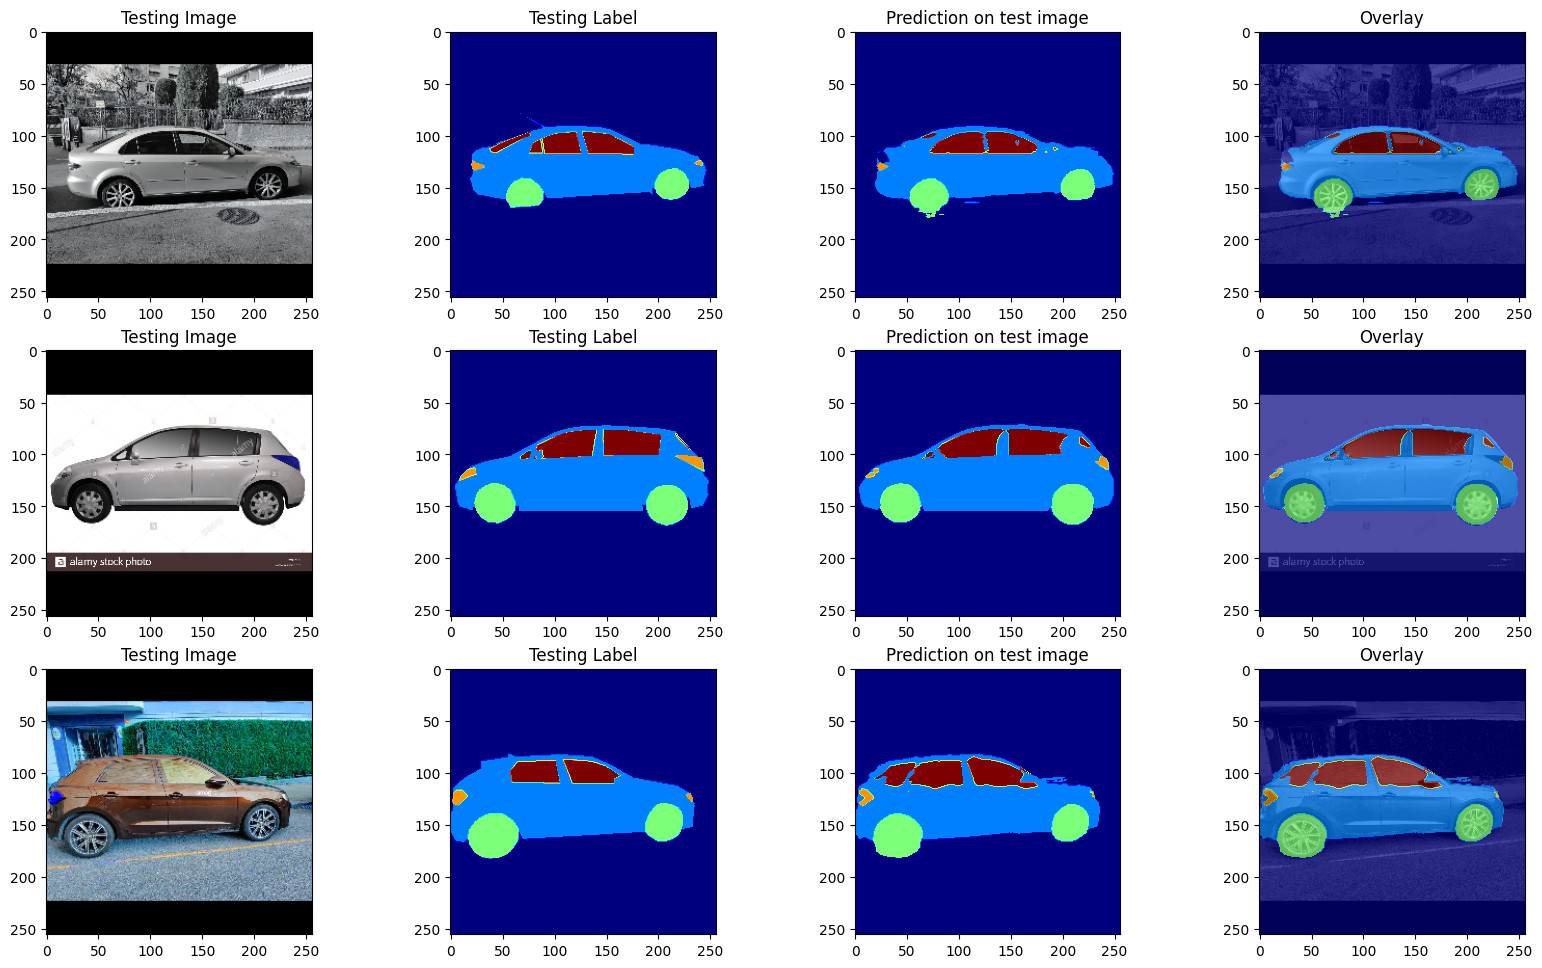

In [19]:
import random
#Mostro alcuni risultati del modello
fig = plt.figure(figsize=(20, 20))

for i in range(3):
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    test_img_input = np.expand_dims(test_img,0)
    ground_truth=y_test[test_img_number]
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    ax = fig.add_subplot(5,4,i*4+1)
    plt.title('Testing Image')
    plt.imshow(test_img, cmap='gray')
    
    ax = fig.add_subplot(5,4,i*4+2)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+3)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+4)
    plt.title('Overlay')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.imshow(predicted_img, cmap='jet', alpha=0.7)
    #plt.show()